In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
# Google Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

# Veri yollarını tanımla
dataset_path = "/content/drive/MyDrive/reduced_dataset"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "validation")
test_dir = os.path.join(dataset_path, "test")

# Veri seti hakkında bilgi topla
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Sınıf sayısı: {num_classes}")
print(f"Sınıflar: {class_names}")

# Görüntü boyutlarını tanımla
img_height, img_width = 224, 224
batch_size = 512

# Veri artırma ve normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Veri yükleyicileri oluştur
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Mounted at /content/drive
Sınıf sayısı: 3
Sınıflar: ['glass', 'paper', 'plastic']
Found 3600 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 675 images belonging to 3 classes.


In [3]:
# Geri çağırmalar (callbacks) oluştur
def create_callbacks(model_name):
    checkpoint_path = f"/content/drive/MyDrive/models/{model_name}_best.h5"
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max',
        save_weights_only=False
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]


In [4]:
# Model oluşturma ve eğitim fonksiyonu
def create_and_train_model(base_model_fn, model_name, epochs=100):
    print(f"\n{'='*50}")
    print(f"Eğitim başlıyor: {model_name}")
    print(f"{'='*50}\n")

    # Temel modeli yükle
    base_model = base_model_fn(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )

    # Temel modeli dondur
    base_model.trainable = False

    # Yeni sınıflandırıcı katmanları ekle
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Model oluştur
    model = Model(inputs=base_model.input, outputs=predictions)

    # Derleme
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Model özetini göster
    print(f"{model_name} özeti:")
    #model.summary()

    # Modeli eğit
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=create_callbacks(model_name)
    )

    # İnce ayar (Fine-tuning) - en üst katmanları eğitilebilir yap
    print(f"\n{model_name} için ince ayar yapılıyor...")

    # Son blok/katmanları eğitilebilir yap
    if model_name == "MobileNetV2":
        for layer in base_model.layers[-20:]:
            layer.trainable = True
    elif model_name == "EfficientNetB0":
        for layer in base_model.layers[-20:]:
            layer.trainable = True

    # Daha düşük öğrenme oranıyla yeniden derle
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # İnce ayar eğitimi
    fine_tune_history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=create_callbacks(f"{model_name}_finetuned")
    )

    # Tüm eğitim geçmişini birleştir
    combined_history = {}
    for k in history.history.keys():
        combined_history[k] = history.history[k] + fine_tune_history.history[k]

    # Test veri seti üzerinde değerlendir
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n{model_name} Test accuracy: {test_acc:.4f}")

    # Modeli kaydet
    model.save(f"/content/drive/MyDrive/models/{model_name}_final.h5")

    # Eğitim ve doğrulama grafiklerini çiz
    plot_training_history(combined_history, model_name)
    evaluate_model(model, model_name)

    return model, combined_history

In [5]:
#Eğitim grafiklerini çizme fonksiyonu
def plot_training_history(history, model_name):
    # Doğruluk (accuracy) grafiği
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Kayıp (loss) grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/models/{model_name}_training_history.png")
    plt.show()

# Kaydetme dizini oluştur
os.makedirs("/content/drive/MyDrive/models", exist_ok=True)



In [6]:
# Confusion matrix ve classification report çizdirme fonksiyonu
def evaluate_model(model, model_name):
    # Test verileri üzerinden tahmin yap
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Görselleştir
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/models/{model_name}_confusion_matrix.png")
    plt.show()


Eğitim başlıyor: MobileNetV2

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 özeti:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - accuracy: 0.4394 - loss: 1.6327  
Epoch 1: val_accuracy improved from -inf to 0.81778, saving model to /content/drive/MyDrive/models/MobileNetV2_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 490s 65s/step - accuracy: 0.4499 - loss: 1.5958 - val_accuracy: 0.8178 - val_loss: 0.4111 - learning_rate: 0.0010
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7910 - loss: 0.5343

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.81778
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7910 - loss: 0.5343 - val_accuracy: 0.8044 - val_loss: 0.4325 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8191 - loss: 0.4666
Epoch 3: val_accuracy improved from 0.81778 to 0.88444, saving model to /content/drive/MyDrive/models/MobileNetV2_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step - accuracy: 0.8209 - loss: 0.4637 - val_accuracy: 0.8844 - val_loss: 0.3136 - learning_rate: 0.0010
Epoch 4/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8750 - loss: 0.4013
Epoch 4: val_accuracy did not improve from 0.88444
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8750 - loss: 0.4013 - val_accuracy: 0.8844 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8661 - loss: 0.3652
Epoch 5: val_accuracy improved from 0.88444 to 0.91111, saving model to /content/drive/MyDrive/models/MobileNetV2_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.8657 - loss: 0.3641 - val_accuracy: 0.9111 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 6/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.8672 - loss: 0.3248
Epoch 6: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.8672 - loss: 0.3248 - val_accuracy: 0.9067 - val_loss: 0.2634 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8800 - loss: 0.3201
Epoch 7: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.8789 - loss: 0.3215 - val_accuracy: 0.9022 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 8/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9121 - loss: 0.2448
Epoch 8: val_accuracy did not improve from 0.91111
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9121 - loss: 0.2448 - val_accuracy: 0.8889 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8849 - loss: 0.2826 - val_accuracy: 0.9156 - val_loss: 0.2461 - learning_rate: 0.0010
Epoch 10/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9375 - loss: 0.2060
Epoch 10: val_accuracy improved from 0.91556 to 0.92000, saving model to /content/drive/MyDrive/models/MobileNetV2_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9375 - loss: 0.2060 - val_accuracy: 0.9200 - val_loss: 0.2460 - learning_rate: 0.0010
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9020 - loss: 0.2551
Epoch 11: val_accuracy did not improve from 0.92000
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9025 - loss: 0.2546 - val_accuracy: 0.9022 - val_loss: 0.2486 - learning_rate: 0.0010
Epoch 12/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9121 - loss: 0.2369
Epoch 12: val_accuracy did not improve from 0.92000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9121 - loss: 0.2369 - val_accuracy: 0.9022 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9105 - loss: 0.2470
Epoch 13: val_accuracy improved from 0.92000 to 0.92444, saving model to /content/drive/MyDrive/models/MobileNetV2_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9109 - loss: 0.2454 - val_accuracy: 0.9244 - val_loss: 0.2259 - learning_rate: 0.0010
Epoch 14/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.9180 - loss: 0.2121
Epoch 14: val_accuracy did not improve from 0.92444
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9180 - loss: 0.2121 - val_accuracy: 0.9244 - val_loss: 0.2235 - learning_rate: 0.0010
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9152 - loss: 0.2231
Epoch 15: val_accuracy did not improve from 0.92444
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.9149 - loss: 0.2234 - val_accuracy: 0.9111 - val_loss: 0.2400 - learning_rate: 0.0010
Epoch 16/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0546
Epoch 16: val_accuracy did not improve from 0.92444
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0546 - val_accuracy: 0.8978 - val_loss: 0.2531 - learning_rate: 0.0010
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.8904 - loss: 0.2818 - val_accuracy: 0.9111 - val_loss: 0.2167 - learning_rate: 1.0000e-04
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9023 - loss: 0.2594
Epoch 2: val_accuracy improved from 0.91111 to 0.91556, saving model to /content/drive/MyDrive/models/MobileNetV2_finetuned_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.9023 - loss: 0.2594 - val_accuracy: 0.9156 - val_loss: 0.2171 - learning_rate: 1.0000e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9208 - loss: 0.2101
Epoch 3: val_accuracy did not improve from 0.91556
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9205 - loss: 0.2101 - val_accuracy: 0.9111 - val_loss: 0.2242 - learning_rate: 1.0000e-04
Epoch 4/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.9336 - loss: 0.1557
Epoch 4: val_accuracy did not improve from 0.91556
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9336 - loss: 0.1557 - val_accuracy: 0.9156 - val_loss: 0.2267 - learning_rate: 1.0000e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9366 - loss: 0.1711
Epoch 5: val_accuracy did not improve from 0.91556
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.9361 - loss: 0.1717 - val_accuracy: 0.9067 - val_loss: 0.2604 - learning_rate: 1.0000e-04
Epoch 6/10
1/7 ━━━━━━━━━━━━━━━━━━━━


MobileNetV2 Test accuracy: 0.9215


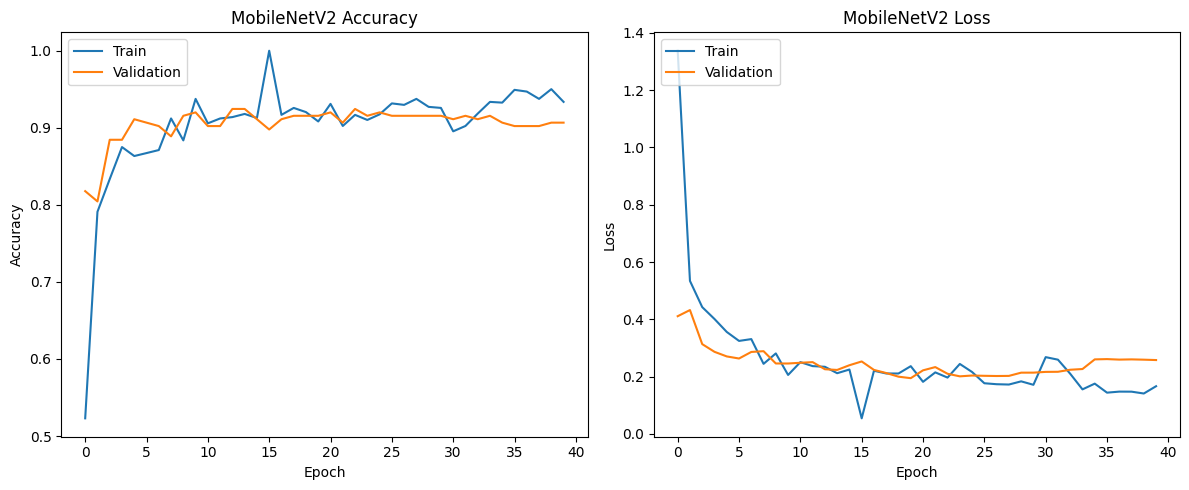

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step

MobileNetV2 - Classification Report:
              precision    recall  f1-score   support

       glass       0.93      0.88      0.90       225
       paper       0.96      0.96      0.96       225
     plastic       0.88      0.92      0.90       225

    accuracy                           0.92       675
   macro avg       0.92      0.92      0.92       675
weighted avg       0.92      0.92      0.92       675



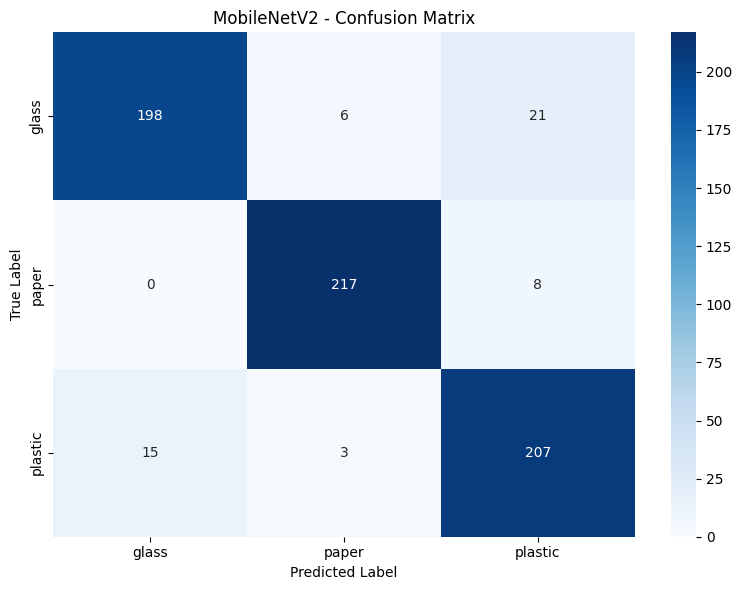


Eğitim başlıyor: EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0 özeti:
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3268 - loss: 1.2840
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/MyDrive/models/EfficientNetB0_best.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.3266 - loss: 1.2828 - val_accuracy: 0.3333 - val_loss: 1.1221 - learning_rate: 0.0010
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3281 - loss: 1.1307

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.3281 - loss: 1.1307 - val_accuracy: 0.3333 - val_loss: 1.1224 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3293 - loss: 1.1544
Epoch 3: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.3289 - loss: 1.1537 - val_accuracy: 0.3333 - val_loss: 1.1073 - learning_rate: 0.0010
Epoch 4/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.3281 - loss: 1.1201
Epoch 4: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.3281 - loss: 1.1201 - val_accuracy: 0.3333 - val_loss: 1.1167 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3410 - loss: 1.1342
Epoch 5: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.3406 - loss: 1.1340 - val_accuracy: 0.3333 - val_loss: 1.1141 - learning_rate: 0.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - accuracy: 0.3508 - loss: 1.1172 - val_accuracy: 0.3333 - val_loss: 1.0985 - learning_rate: 1.0000e-04
Epoch 2/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3223 - loss: 1.1203
Epoch 2: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3223 - loss: 1.1203 - val_accuracy: 0.3333 - val_loss: 1.0985 - learning_rate: 1.0000e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3301 - loss: 1.1206
Epoch 3: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.3299 - loss: 1.1199 - val_accuracy: 0.3333 - val_loss: 1.0985 - learning_rate: 1.0000e-04
Epoch 4/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.3594 - loss: 1.1083
Epoch 4: val_accuracy did not improve from 0.33333
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.3594 - loss: 1.1083 - val_accuracy: 0.3333 - val_loss: 1.0985 - learning_rate: 1.0000e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━


EfficientNetB0 Test accuracy: 0.3333


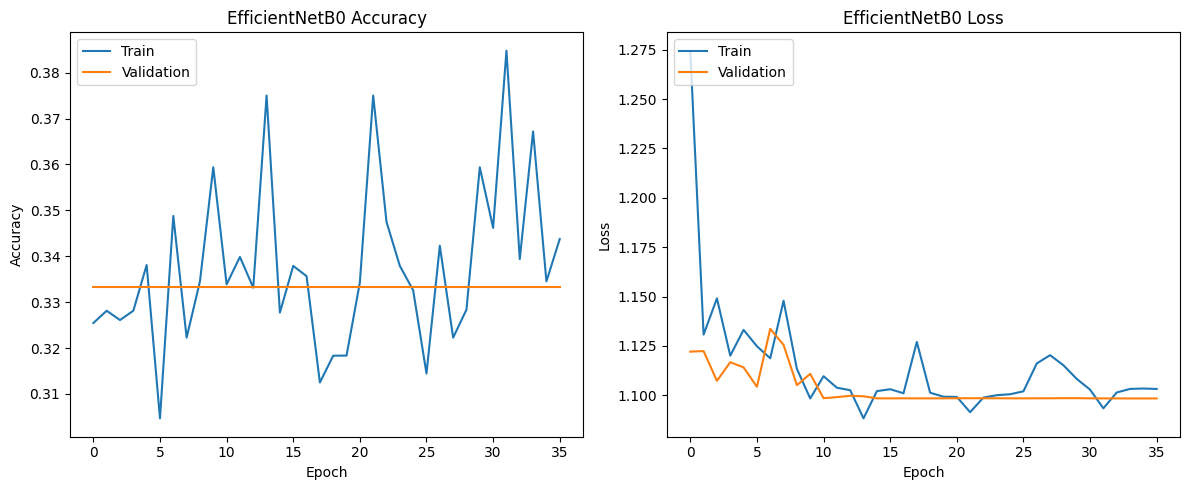

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step

EfficientNetB0 - Classification Report:
              precision    recall  f1-score   support

       glass       0.00      0.00      0.00       225
       paper       0.00      0.00      0.00       225
     plastic       0.33      1.00      0.50       225

    accuracy                           0.33       675
   macro avg       0.11      0.33      0.17       675
weighted avg       0.11      0.33      0.17       675



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


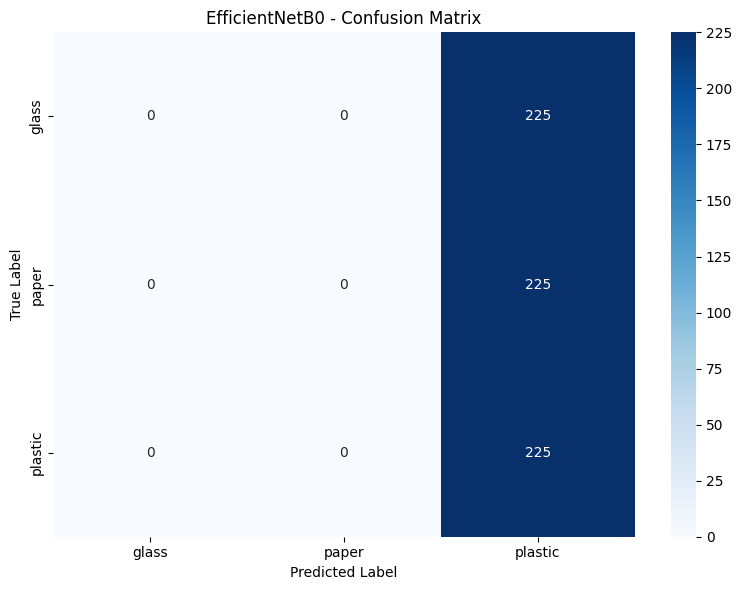

In [7]:
# Her modeli eğit
# 1. MobileNetV2
mobilenet_model, mobilenet_history = create_and_train_model(MobileNetV2, "MobileNetV2")

# 2. EfficientNetB0
efficientB0_model, efficientB0_history = create_and_train_model(EfficientNetB0, "EfficientNetB0")


In [8]:
# Tüm modellerin performansını karşılaştır
def compare_models():
    models = [
        ("MobileNetV2", mobilenet_history),
        ("EfficientNetB0", efficientB0_history)
    ]

    plt.figure(figsize=(12, 10))

    # Doğruluk (accuracy) karşılaştırması
    plt.subplot(2, 1, 1)
    for name, history in models:
        plt.plot(history['val_accuracy'])

    plt.title('Model Karşılaştırması - Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([name for name, _ in models], loc='lower right')

    # Kayıp (loss) karşılaştırması
    plt.subplot(2, 1, 2)
    for name, history in models:
        plt.plot(history['val_loss'])

    plt.title('Model Karşılaştırması - Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([name for name, _ in models], loc='upper right')

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/models/model_comparison.png")
    plt.show()


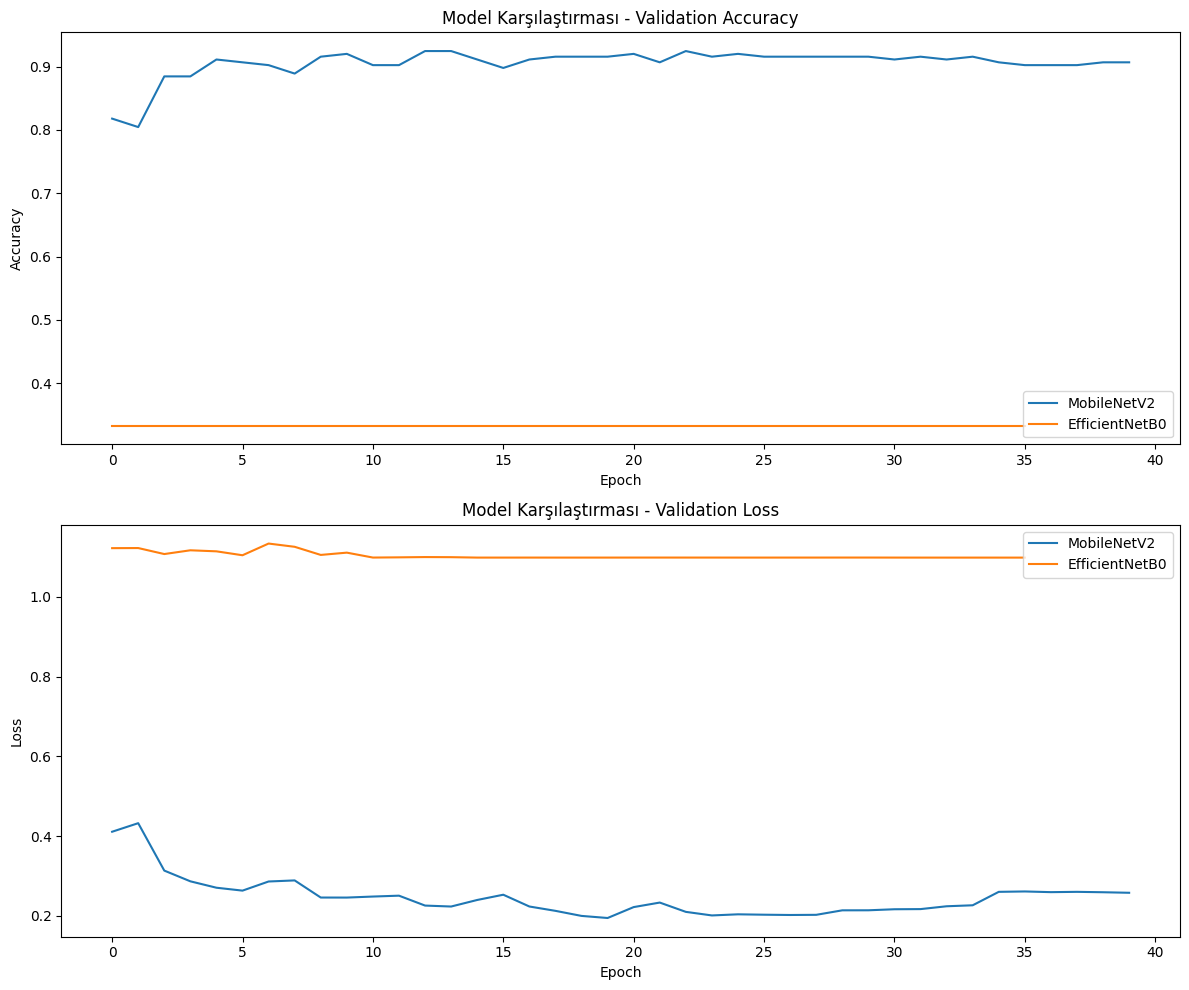

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - accuracy: 0.9197 - loss: 0.2353
MobileNetV2 Test Accuracy: 0.9215
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - accuracy: 0.2626 - loss: 1.1006
EfficientNetB0 Test Accuracy: 0.3333

En iyi performans gösteren model: MobileNetV2, Test Accuracy: 0.9215


In [9]:
# Modelleri karşılaştır
compare_models()

# En iyi performans gösteren modeli belirle
def find_best_model():
    models = [
        ("MobileNetV2", mobilenet_model),
        ("EfficientNetB0", efficientB0_model)
    ]

    best_acc = 0
    best_model_name = ""

    for name, model in models:
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"{name} Test Accuracy: {test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_name = name

    print(f"\nEn iyi performans gösteren model: {best_model_name}, Test Accuracy: {best_acc:.4f}")

# En iyi modeli bul
find_best_model()